Install

In [1]:
#test
#(studiolab) studio-lab-user@default:~/sagemaker-studiolab-notebooks/AI-OT24$ tensorboard --logdir logs/
#!pip install -q ib_insync numpy pandas yfinance matplotlib ta seaborn gymnasium stable-baselines3 sb3-contrib tensorflow scikit-learn quantstats imitation fredapi typing


Install requirements and import all functions

In [1]:
import os
os.chdir("/home/studio-lab-user/sagemaker-studiolab-notebooks/AI-OT24/Reinforcement-Learning-Stock-Porfolio-Managment")
!pip install -q -r requirements.txt

In [2]:
import sys
sys.path.append('./utils')
import trading_functions  # Import your library
import inspect  # Used to inspect the module

# Get all functions from the library
all_functions = [func for func, obj in inspect.getmembers(trading_functions) if inspect.isfunction(obj)]

# Print the function names
print("Functions in the 'trading_functions' library:")
for function in all_functions:
    print(function)

2024-11-18 03:40:29.722845: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Functions in the 'trading_functions' library:
HER
accuracy_score
bin_reward_func
calculate_accuracy
check_env
clear_output
collect_expert_data
create_env
create_env_unique
create_evaluation_env
create_training_env
evaluate_all
evaluate_best
evaluate_buy
evaluate_model
evaluate_policy
evaluate_various
is_significant_reward_improvement
linear_schedule
lnr_reward_func
make_vec_env
save_model
smp_reward_func
sqh_reward_func
sqs_reward_func
stp_reward_func
train_model
train_test_split


In [3]:
import sys
sys.path.append('./utils')
from trading_functions import *
#from trading_functions import linear_schedule, TradingEnvUnique, TradingEnvUniqueMultiple, create_env, create_env_unique, evaluate_best, evaluate_buy, evaluate_model, evaluate_various, evaluate_all

Import

In [4]:
# Core Libraries
import os
import sys
import time
import datetime
import warnings
#warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = info, 2 = warnings, 3 = errors

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Financial Data
import yfinance as yf
import quantstats as qs
import ta

# Machine Learning - Supervised Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Machine Learning - Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy

# Reinforcement Learning and Environments
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, DDPG, DQN, HER, PPO, SAC, TD3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import (
    EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement
)
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecCheckNan
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from sb3_contrib import ARS, MaskablePPO, RecurrentPPO, QRDQN, TRPO

# Imitation Learning
from imitation.algorithms import bc
from imitation.testing.reward_improvement import is_significant_reward_improvement
from imitation.data.types import Transitions

# Interactive Brokers API
from ib_insync import *

from typing import Callable

from collections import Counter

clear_output()


API Fred

In [5]:
from fredapi import Fred
fred = Fred(api_key='xxxxxxxxxxxxxxx')

RL

Using cpu device
Logging to ./logs/log_2024-11-18_03-43-35/0_run_1
Train
Total return of portfolio: 225.25%


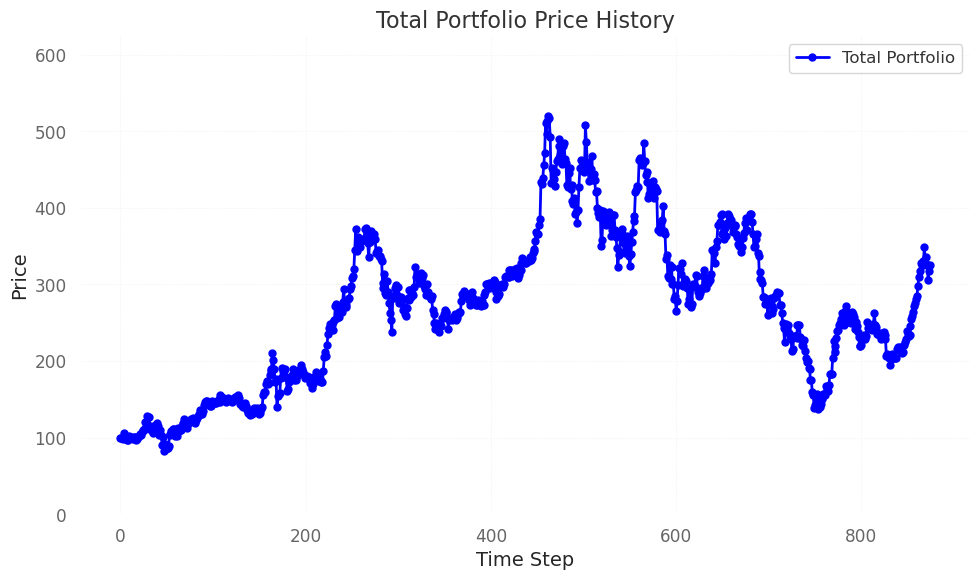

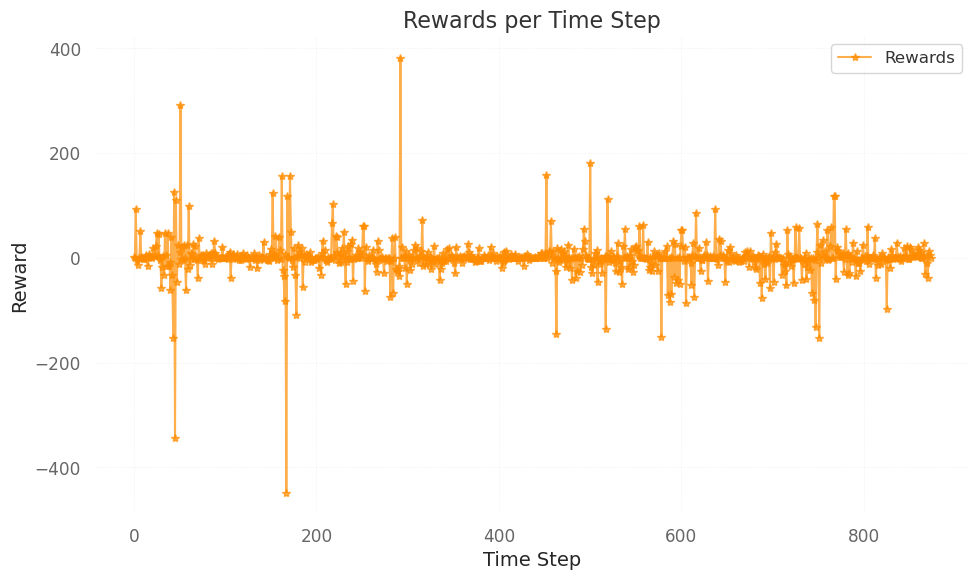

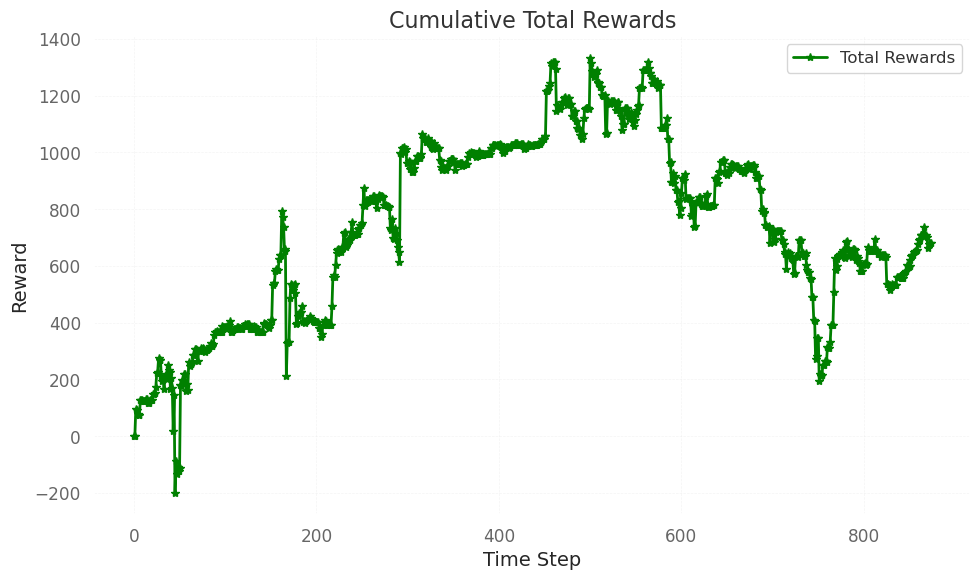

Total rewards: 681.795477676054
Valid
Total return of portfolio: -55.58%


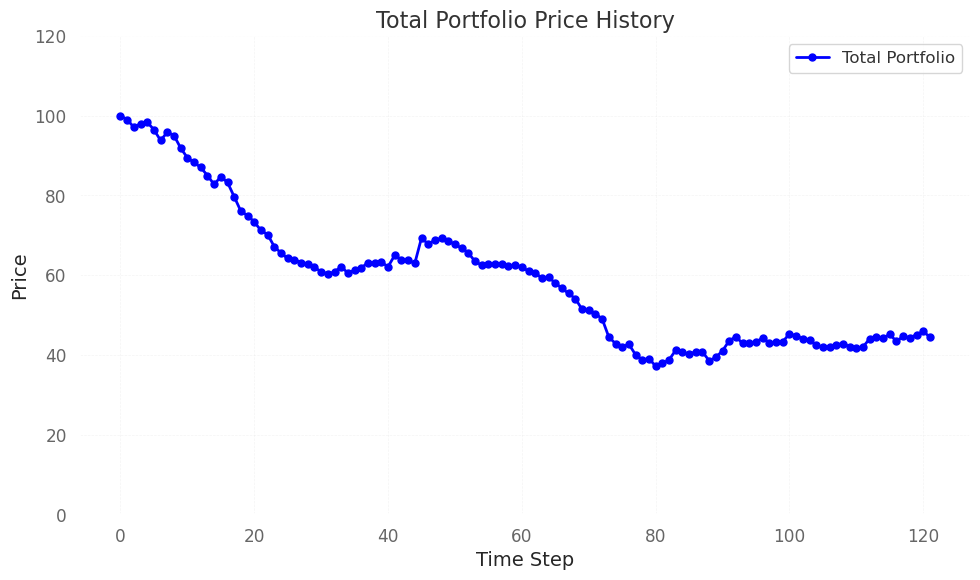

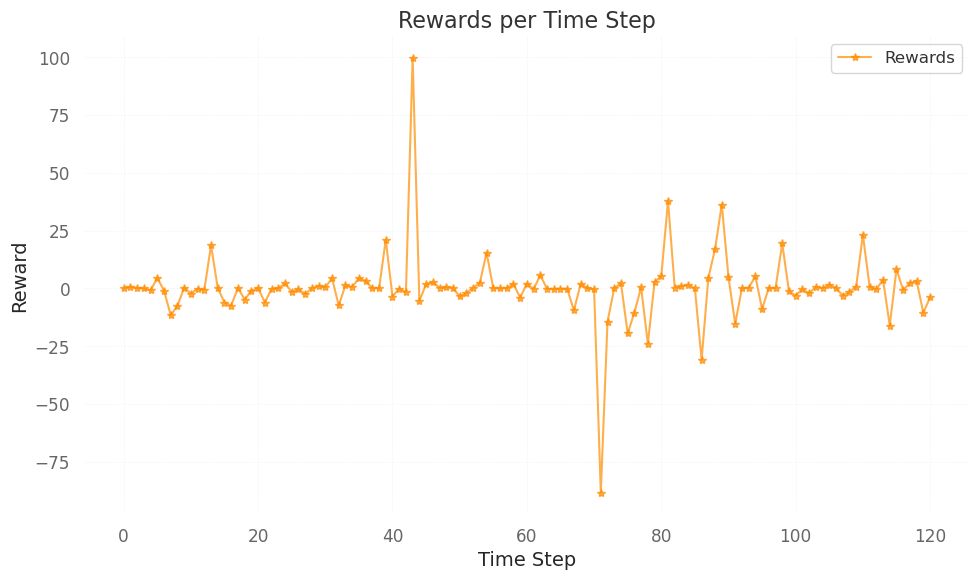

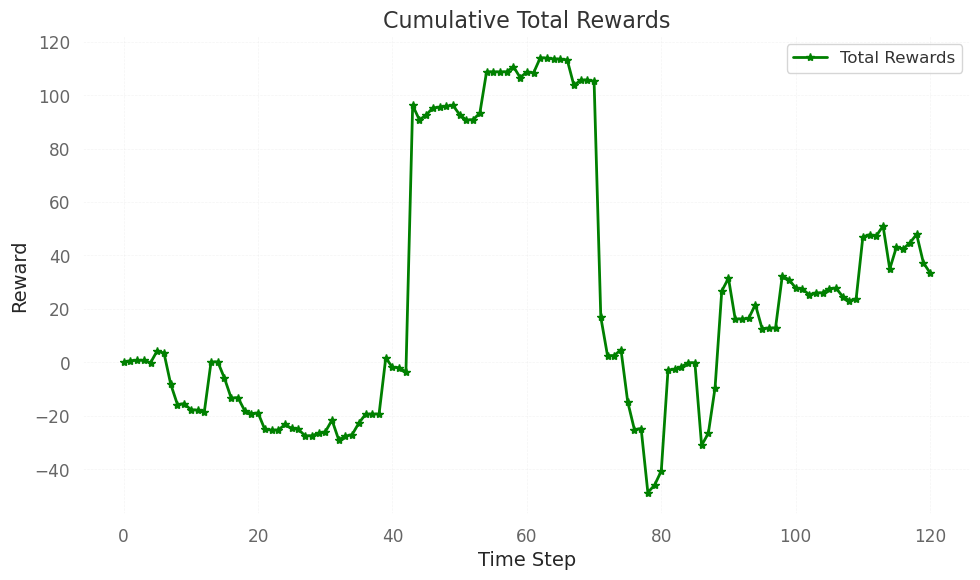

Total rewards: 33.47302052188859
Test
Total return of portfolio: 20.64%


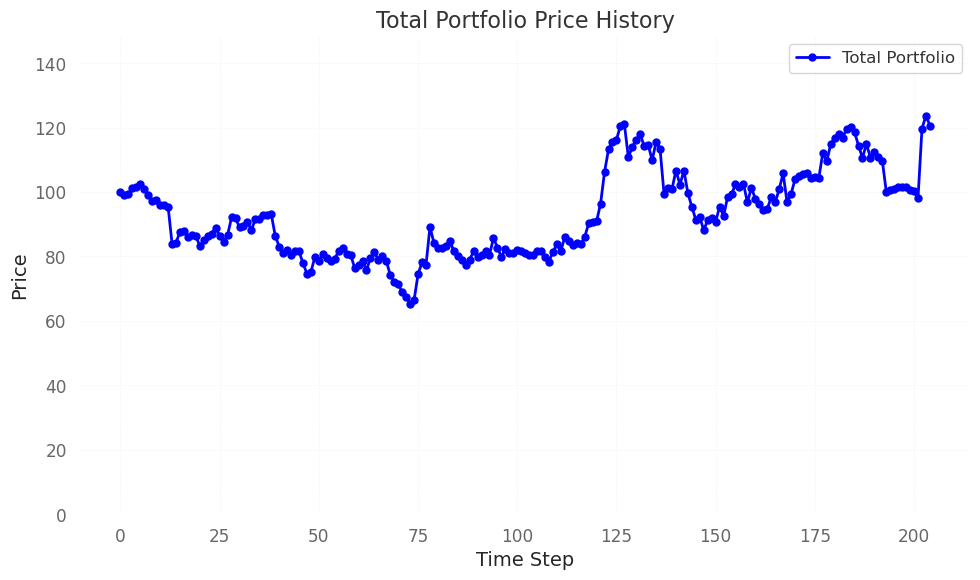

In [ ]:
# Define constants
SEED = 1
history_length = 5
reward_type = 'SQS'
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
n_envs = 10
n_steps = 8
total_timesteps = 10_000
batch_size = 16
learning_rate = 0.001
ent_coef = 0.10
log_interval = 1_000
eval_freq=1_000

current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_save_dir = f'./models/model_{current_date}'
log_dir = f'./logs/log_{current_date}'

# Training environment
env, vec_env = create_training_env(history_length, reward_type, '2020-01-01', '2023-06-30', stocks, n_envs)

# Validation environment
valid_env, vec_valid_env = create_evaluation_env(history_length, reward_type, '2023-07-01', '2023-12-30', stocks)

# Test environment
test_env, _ = create_evaluation_env(history_length, reward_type, '2024-01-01', '2024-10-30', stocks, n_envs=1)

# Evaluation callback for saving the best model
eval_callback = EvalCallback(
    vec_valid_env,
    n_eval_episodes=1,
    eval_freq=eval_freq,
    deterministic=True,
    verbose=1,
    best_model_save_path=model_save_dir,
)
stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)

# Train the model
model = train_model(
    model_name="PPO",  # Can be 'PPO', 'A2C', or 'DQN'
    create_model=True,
    vec_env=vec_env,
    iterations=1,
    train_timesteps=total_timesteps,
    log_frec=log_interval,
    log_base_dir=log_dir,
    n_steps=n_steps,
    batch_size=batch_size,
    learning_rate=learning_rate,
    ent_coef=ent_coef
)

# Evaluate the model
evaluate_model(env, model, 'Train', SEED, has_policy=False)
evaluate_model(valid_env, model, 'Valid', SEED, has_policy=False)
evaluate_model(test_env, model, 'Test', SEED, has_policy=False)

# Save the model to the Tests folder
save_model(model, model_save_dir)

# Close environments
env.close()
valid_env.close()
test_env.close()
vec_env.close()
vec_valid_env.close()

BC

2024-11-18 00:33:00.202844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 00:33:07.782008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environ

BC Learner rewards before training:
Mean reward: 81.0664980370625 +/- 0.00
--------------------------------
| batch_size        | 118      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00195 |
|    entropy        | 1.95     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 129      |
|    loss           | 1.94     |
|    neglogp        | 1.95     |
|    prob_true_act  | 0.143    |
|    samples_so_far | 118      |
--------------------------------
BC Learner rewards after training:
Mean reward: 1513.0308379012931 +/- 0.00
BC
Total return of portfolio: 117.74%


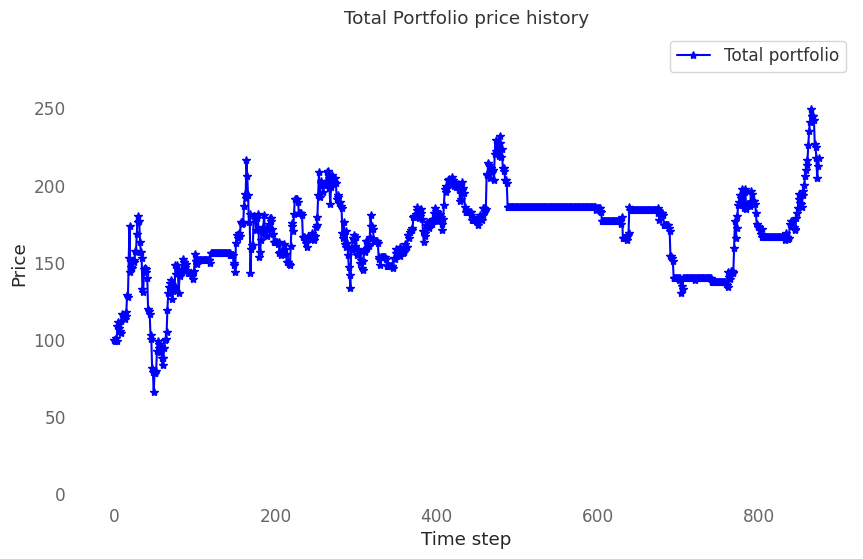

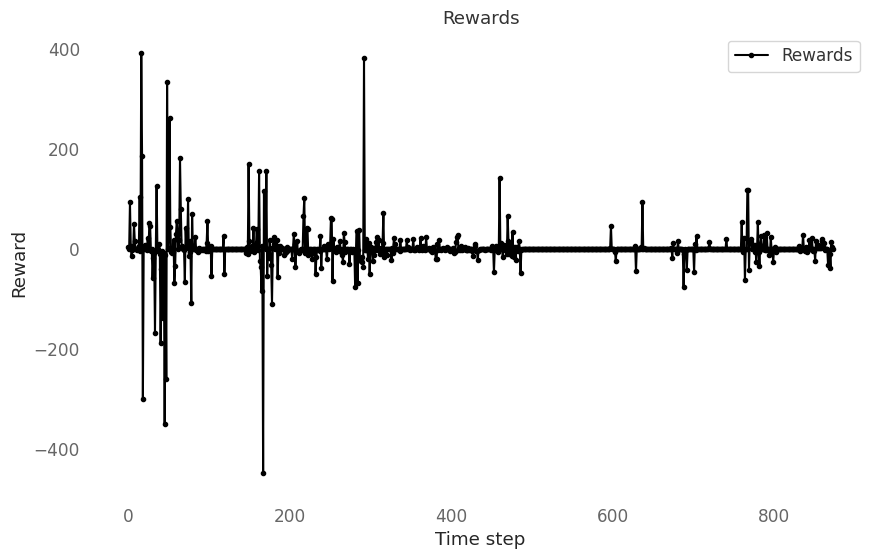

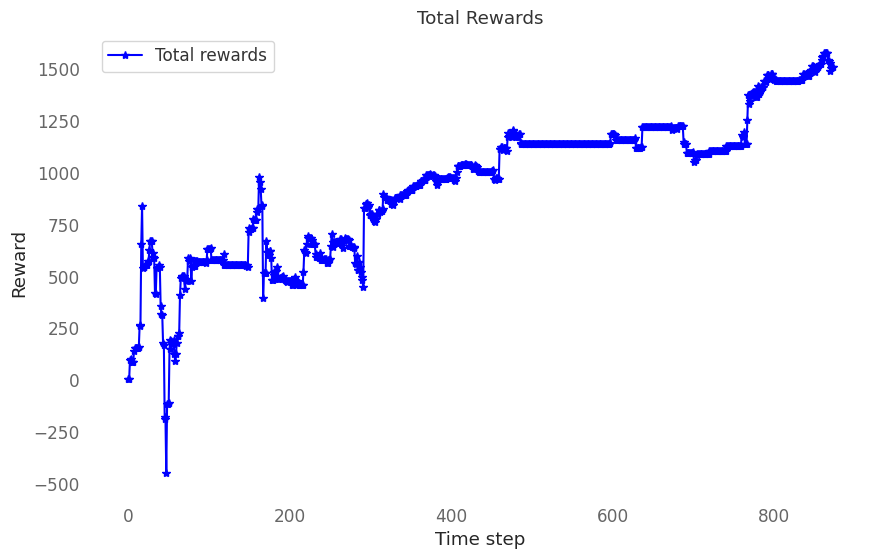

Total rewards: 1513.0308357711137
Action Counts:
6    422
5    334
4    113
2      3
0      2
Name: count, dtype: int64
BC
Total return of portfolio: -35.29%


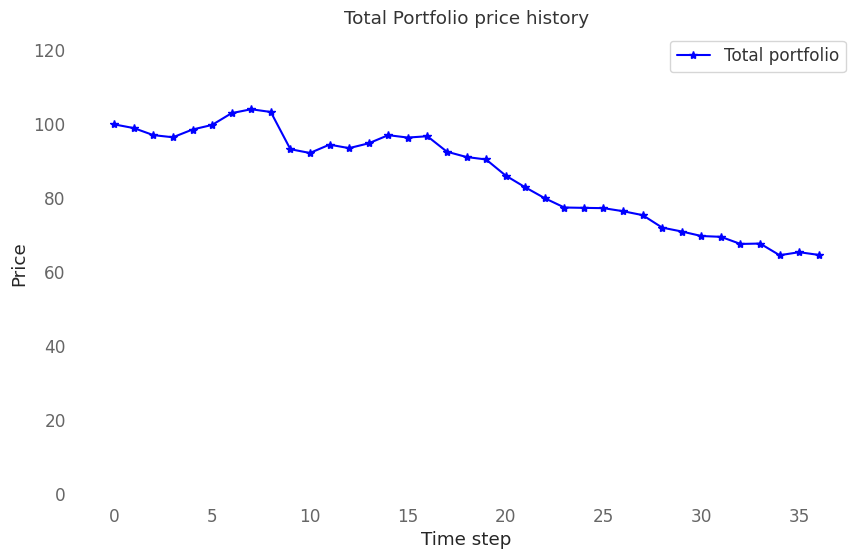

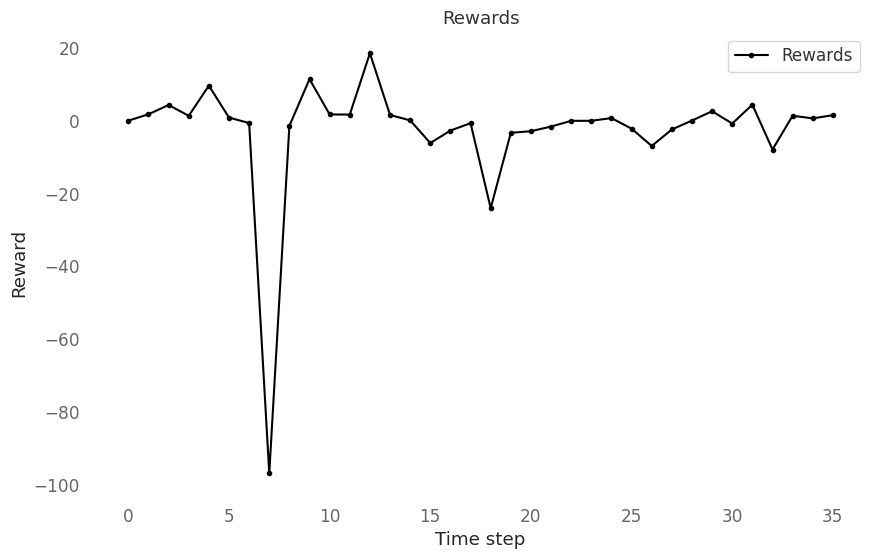

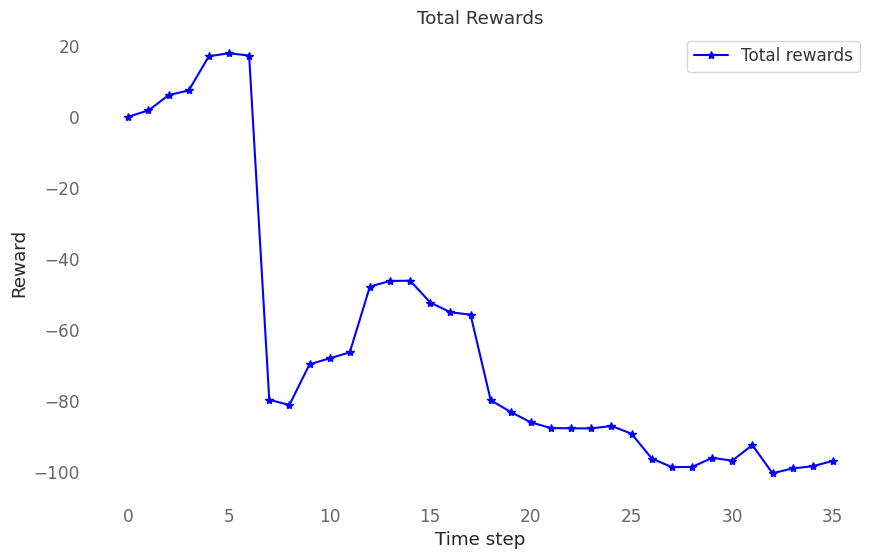

Total rewards: -96.75635377286932
Action Counts:
0    13
5    11
2     5
3     3
1     3
6     1
Name: count, dtype: int64
Best
Total return of portfolio: 646895385.55%


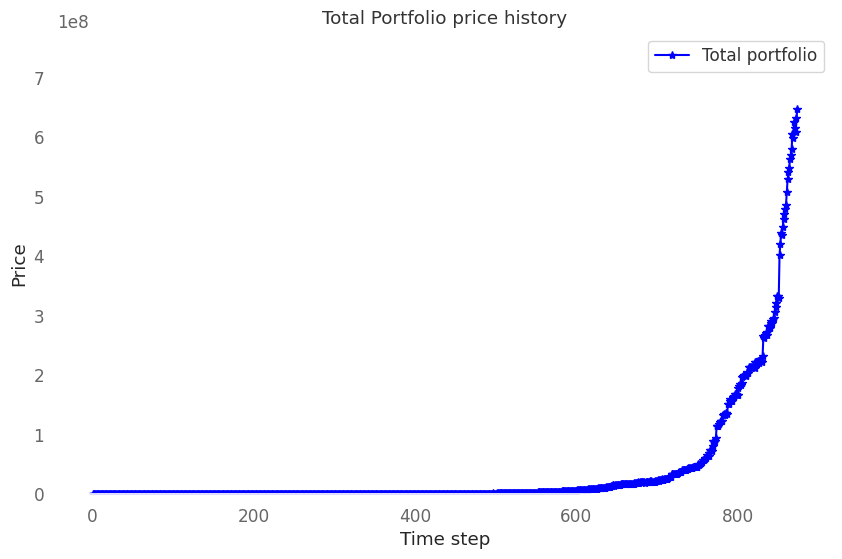

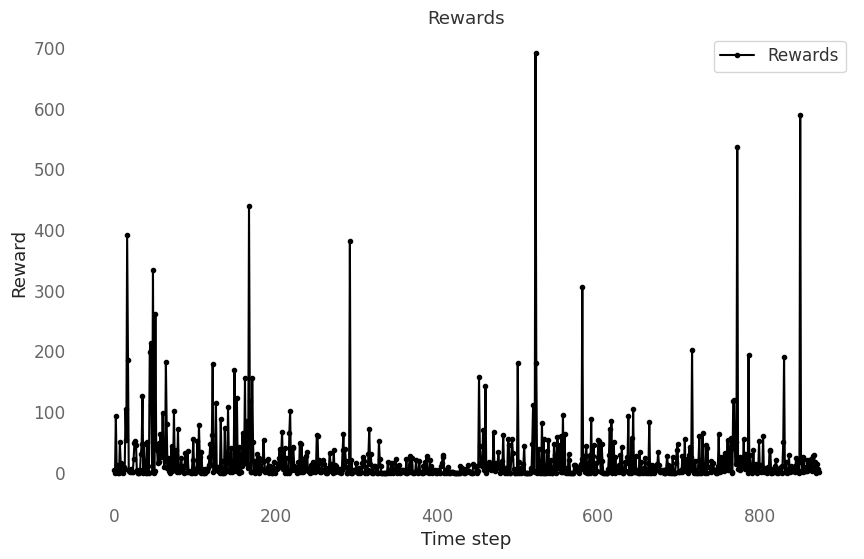

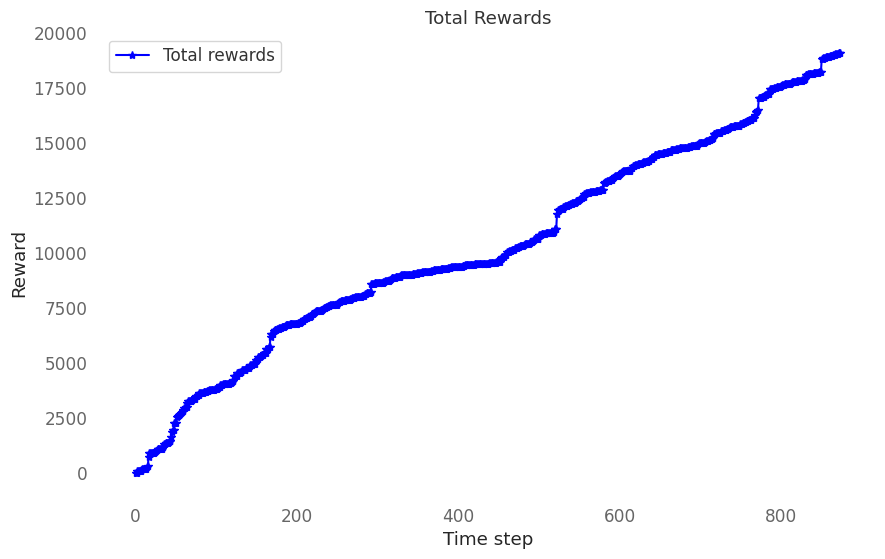

Total rewards: 19089.638735221237
Action Counts:
6    242
5    223
4    176
2     93
1     61
0     46
3     33
Name: count, dtype: int64


In [15]:
# Define constants
SEED = 1
history_length = 5
reward_type = 'SQS'
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
n_envs = 1
n_steps = 8
total_timesteps = 10_000
batch_size = 64
learning_rate = 0.001
ent_coef = 0.10
log_interval = 10_000
eval_freq=1_000
log_dir = './logs'
model_save_dir = './models'

# Training environment
env, vec_env = create_training_env(history_length, reward_type, '2020-01-01', '2023-06-30', stocks, n_envs)
valid_env, vec_valid_env = create_training_env(history_length, reward_type, '2023-07-01', '2023-08-30', stocks, 1)
transitions, expert_actions = collect_expert_data(env, seed=SEED)
bc_trainer = train_model(
    model_name="BC",
    create_model=True,
    env=env,
    transitions=transitions,
    bc_batches=1000,
    bc_log_interval=1_000,
    batch_size=118,
    seed=1
)
model_actions, returns, total_reward = evaluate_model(env, name="BC",has_policy=True,SEED=SEED,trainer=bc_trainer)
action_counts = pd.Series(model_actions).value_counts()
print("Action Counts:")
print(action_counts)
model_actions, returns, total_reward = evaluate_model(valid_env, name="BC",has_policy=True,SEED=SEED,trainer=bc_trainer)
action_counts = pd.Series(model_actions).value_counts()
print("Action Counts:")
print(action_counts)
best_actions, best_returns, total_reward = evaluate_best(env, expert_actions, SEED)
action_counts = pd.Series(best_actions).value_counts()
print("Action Counts:")
print(action_counts)

# Close environments
env.close()
valid_env.close()
vec_env.close()
vec_valid_env.close()